In [23]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import pipeline, preprocessing, ensemble, linear_model, svm, tree
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, ShuffleSplit, cross_validate
from sklearn import model_selection, metrics

#import models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from df_transformers import SelectColumnsTransformer

%matplotlib inline

In [24]:
train_data = pd.read_csv("data/output/preprocessed_train_data.csv", index_col="PassengerId")
test_data = pd.read_csv("data/output/preprocessed_test_data.csv", index_col="PassengerId")
print(f"Shape of train data: {train_data.shape}. Shape of test data: {test_data.shape}")

Shape of train data: (891, 53). Shape of test data: (418, 52)


### Разделяем выборку на трейн и тест

In [26]:
X = train_data.drop(['FareBin_(-0.001, 7.896]',
       'FareBin_(-0.001, 7.91]', 'FareBin_(14.454, 31.0]',
       'FareBin_(14.454, 31.5]', 'FareBin_(31.0, 512.329]',
       'FareBin_(31.5, 512.329]', 'FareBin_(7.896, 14.454]',
       'FareBin_(7.91, 14.454]', 'AgeBin_(-0.076, 15.2]',
       'AgeBin_(-0.08, 16.0]', 'AgeBin_(15.2, 30.4]', 'AgeBin_(16.0, 32.0]',
       'AgeBin_(30.4, 45.6]', 'AgeBin_(32.0, 48.0]', 'AgeBin_(45.6, 60.8]',
       'AgeBin_(48.0, 64.0]', 'AgeBin_(60.8, 76.0]', 'AgeBin_(64.0, 80.0]',
       'Survived'], axis=1)
y = train_data['Survived']
X.shape

(891, 34)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Define a cross validation strategy

In [28]:
seed = 3
scoring = 'accuracy'
n_folds = 7

def accuracy_cv(model):
    kfold = KFold(n_splits=n_folds, random_state=seed)
    return cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)

In [29]:
seed = 3
scoring = 'accuracy'
n_folds = 7

def accuracy_cv_t(model):
    kfold = KFold(n_splits=n_folds, random_state=seed)
    result = dict()
    result['train_score'] = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    result['test_score'] = metrics.accuracy_score(y_test, predictions)
    return result

## Models

In [45]:
# источник - https://www.kaggle.com/kabure/eda-pipelines-v2-0-easy-to-begineers

clfs = []

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 

clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier(n_estimators=100))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

In [31]:
models = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    #naive_bayes.BernoulliNB(),
    #naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    #neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    #discriminant_analysis.LinearDiscriminantAnalysis(),
    #discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [17]:
# Создадим таблицу для сравнения метрик алгоритмов
MLA_columns = ['MLA Name', 'MLA Train Accuracy Mean', 'MLA Train Accuracy 3*STD']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# Создадим таблицу для сравнения предсказаний алгоритмов
MLA_predict = train_data['Survived']

row_index = 0
for name, model  in clfs:
    MLA_name = name
    MLA_compare.loc[row_index, 'MLA Name'] = name
    
    cv_results = accuracy_cv_t(model)
    
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Train Accuracy 3*STD'] = cv_results['train_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions - see section 6 for usage
    #model.fit(X, y)
    #MLA_predict[MLA_name] = model.predict(X)
    
    row_index+=1

C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
# Создадим таблицу для сравнения метрик алгоритмов
MLA_columns = ['MLA Name', 'MLA Train Accuracy Mean', 'MLA Train Accuracy 3*STD']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# Создадим таблицу для сравнения предсказаний алгоритмов
MLA_predict = train_data['Survived']

row_index = 0
for model in models:
    MLA_name = model.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    
    cv_results = accuracy_cv_t(model)
    
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Train Accuracy 3*STD'] = cv_results['train_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions - see section 6 for usage
    #model.fit(X, y)
    #MLA_predict[MLA_name] = model.predict(X)
    
    row_index+=1

AdaBoostClassifier
BaggingClassifier
ExtraTreesClassifier
GradientBoostingClassifier
RandomForestClassifier
LogisticRegressionCV


C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase 

PassiveAggressiveClassifier
RidgeClassifierCV
SGDClassifier
Perceptron
SVC


C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


NuSVC


C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


LinearSVC
DecisionTreeClassifier
ExtraTreeClassifier
XGBClassifier


C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Train Accuracy Mean,MLA Train Accuracy 3*STD,MLA Test Accuracy Mean
3,GradientBoostingClassifier,0.817014,0.0895718,0.843284
15,XGBClassifier,0.805778,0.0799996,0.828358
5,LogisticRegressionCV,0.826645,0.0933743,0.817164
7,RidgeClassifierCV,0.831461,0.0697819,0.817164
0,AdaBoostClassifier,0.799358,0.0872108,0.813433
4,RandomForestClassifier,0.786517,0.0936223,0.813433
2,ExtraTreesClassifier,0.776886,0.090857,0.809701
8,SGDClassifier,0.691814,0.122011,0.809701
12,LinearSVC,0.76565,0.21045,0.809701
1,BaggingClassifier,0.788122,0.0834053,0.798507


Text(0, 0.5, 'Algorithm')

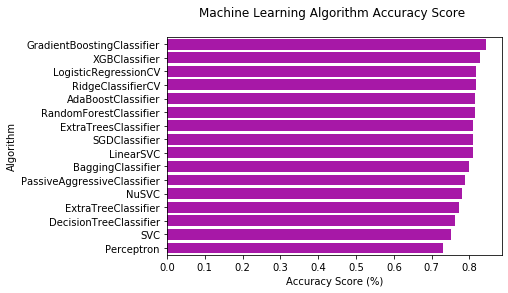

In [51]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [42]:
results, names  = [], [] 

for name, model  in clfs:
    cv_results = accuracy_cv(model)
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

LogReg: 0.823435 (+/- 0.022241)
XGBClassifier: 0.805778 (+/- 0.026667)
KNN: 0.817014 (+/- 0.021415)
DecisionTreeClassifier: 0.744783 (+/- 0.045627)
RandomForestClassifier: 0.794543 (+/- 0.029857)
GradientBoostingClassifier: 0.818620 (+/- 0.025073)
RidgeClassifier: 0.834671 (+/- 0.022241)
BaggingRidgeClassifier: 0.800963 (+/- 0.023808)
ExtraTreesClassifier: 0.775281 (+/- 0.026179)


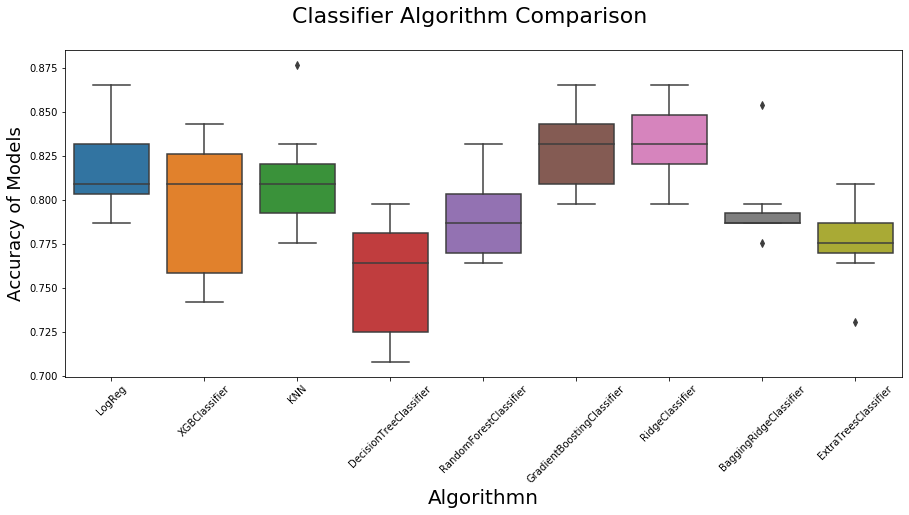

In [9]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [101]:
# Лучшее значение дает GradientBoostingClassifier
gbc = Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))])
gbc.fit(X_train, y_train)
predictions = gbc.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))

0.835820895522388


last result 0.835820895522388

## Test data submission

In [102]:
test_data.shape

(418, 52)

In [103]:
gbc.fit(X, y)
predicted = gbc.predict(test_data)
test_data["Survived"] = predicted
test_data["Survived"].to_csv('gbc.csv', header=True)

In [104]:
test_data["Survived"].head()

PassengerId
892    0
893    0
894    0
895    0
896    1
Name: Survived, dtype: int64